In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Importar las clases y funciones personalizadas
from ROUTINES.data_preprocessing.tng50_data_processor import TNG50DataProcessor
from ROUTINES.data_preprocessing.rotation_handler import RotationHandler
from ROUTINES.data_preprocessing.velocity_escape_calculator import VelocityEscapeCalculator
from ROUTINES.filtering.filtering import create_velocity_grid, filter_data_by_velocity, apply_convex_hull_filter
from ROUTINES.visualization.visualization_handler import visualize_convex_hull
from ROUTINES.filtering.density_based_spatial_clustering import apply_dbscan_filter, Points_no_outliers

# Directorio y archivos a procesar
data_dir = 'DATA/raw'
data_dir_processed = 'DATA/processed'

/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [3]:
def plot_orthogonal_projections(df_filtered, title_prefix="Proyección Ortogonal"):
    """
    Función para graficar las proyecciones ortogonales de los datos filtrados en los planos XY, XZ, YZ.
    
    :param df_filtered: DataFrame con los datos filtrados que contienen las columnas 'x', 'y', 'z'.
    :param title_prefix: Título a usar como prefijo en los gráficos.
    """
    
    # Crear figura para las tres proyecciones ortogonales
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Determinar los límites para asegurar que los tres gráficos tengan la misma escala
    x_limits = [df_filtered['x'].min(), df_filtered['x'].max()]
    y_limits = [df_filtered['y'].min(), df_filtered['y'].max()]
    z_limits = [df_filtered['z'].min(), df_filtered['z'].max()]

    # Definir los límites comunes
    common_limits = [-40,40 ]

    # Proyección en el plano XY
    axs[0].scatter(df_filtered['x'], df_filtered['y'], s=0.01, color='blue')
    axs[0].set_title(f'{title_prefix} XY')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    axs[0].axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    axs[0].set_xlim(common_limits)
    axs[0].set_ylim(common_limits)
    axs[0].set_aspect('equal')

    # Proyección en el plano XZ
    axs[1].scatter(df_filtered['x'], df_filtered['z'], s=0.01, color='green')
    axs[1].set_title(f'{title_prefix} XZ')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Z')
    axs[1].axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    axs[1].axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    axs[1].set_xlim(common_limits)
    axs[1].set_ylim(common_limits)
    axs[1].set_aspect('equal')

    # Proyección en el plano YZ
    axs[2].scatter(df_filtered['y'], df_filtered['z'], s=0.01, color='red')
    axs[2].set_title(f'{title_prefix} YZ')
    axs[2].set_xlabel('Y')
    axs[2].set_ylabel('Z')
    axs[2].axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    axs[2].axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    axs[2].set_xlim(common_limits)
    axs[2].set_ylim(common_limits)
    axs[2].set_aspect('equal')

    # Ajustar la disposición de la figura
    plt.tight_layout()
    plt.show()


In [4]:
# Nombre de los archivos
halo_files = ['dhc_halo_167397.gas', 'dhc_halo_198184.gas', 'dhc_halo_167393.gas', 'dhc_halo_368843.gas', 'dhc_halo_307487.gas','dhc_halo_117260.gas' ]

# Cargar cada archivo en un DataFrame de Pandas
archivos_dataframes = []
for archivo in halo_files:
    # Construir la ruta completa al archivo
    ruta_completa = os.path.join(data_dir, archivo)
    
    # Leer el archivo en un DataFrame
    df = pd.read_csv(ruta_completa, sep=' ', names=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho'], header=None)
    archivos_dataframes.append(df)

# Mostrar la lista de DataFrames para verificar la carga
for i, df in enumerate(archivos_dataframes):
    print(f"Archivo {halo_files[i]} cargado con {len(df)} filas.")


Archivo dhc_halo_167397.gas cargado con 125516 filas.
Archivo dhc_halo_198184.gas cargado con 171645 filas.
Archivo dhc_halo_167393.gas cargado con 4632364 filas.
Archivo dhc_halo_368843.gas cargado con 3874218 filas.
Archivo dhc_halo_307487.gas cargado con 198519 filas.
Archivo dhc_halo_117260.gas cargado con 400298 filas.


## halo_167397

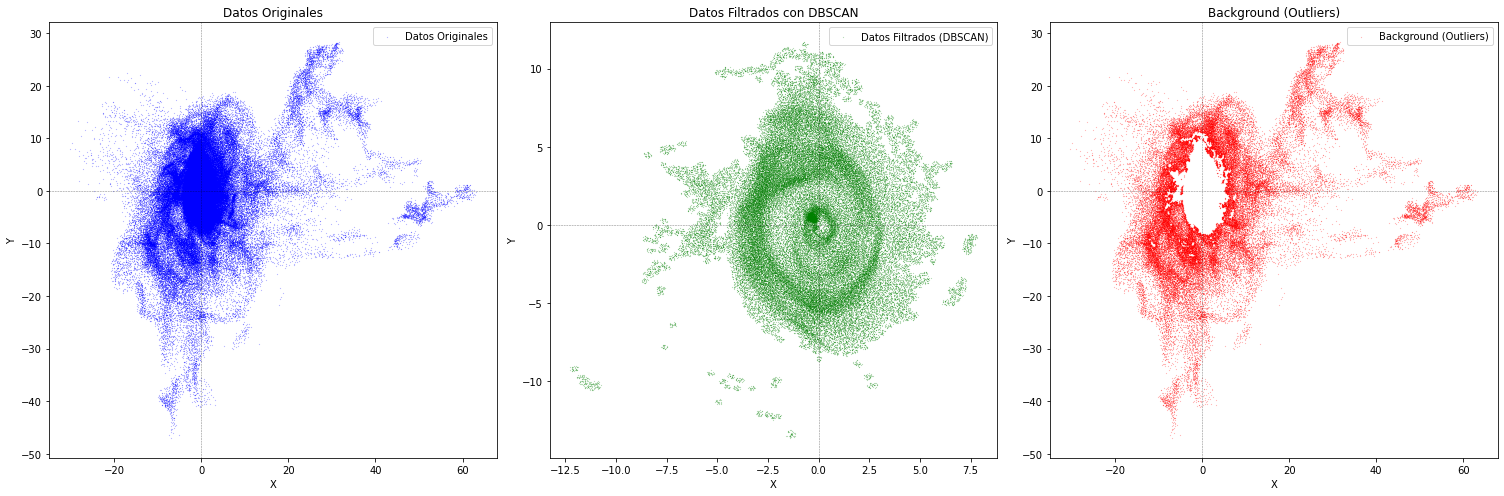

In [5]:
df_halo_167397 = archivos_dataframes[0]
df_filtered, background, eps, min_samples, labels= apply_dbscan_filter(df_halo_167397, eps =0.17, min_samples=20)

# Gráfico de los datos originales
plt.figure(figsize=(21, 7))

# Subplot 1: Datos Originales
plt.subplot(1, 3, 1)
plt.scatter(df_halo_167397['x'], df_halo_167397['y'], s=0.01, c='blue', label='Datos Originales')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Datos Originales')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Subplot 2: Datos Filtrados con DBSCAN
plt.subplot(1, 3, 2)
plt.scatter(df_filtered['x'], df_filtered['y'], s=0.01, c='green', label='Datos Filtrados (DBSCAN)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Datos Filtrados con DBSCAN')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Subplot 3: Background (Outliers)
plt.subplot(1, 3, 3)
plt.scatter(background['x'], background['y'], s=0.01, c='red', label='Background (Outliers)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Background (Outliers)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Ajustar la disposición de los subplots
plt.tight_layout()
plt.show()

In [6]:
total_points_origin = len(df_halo_167397)
total_points_dbscan = len(df_filtered)
total_points_background = len(background)
print(total_points_origin, total_points_dbscan, total_points_background)

125516 71465 54051


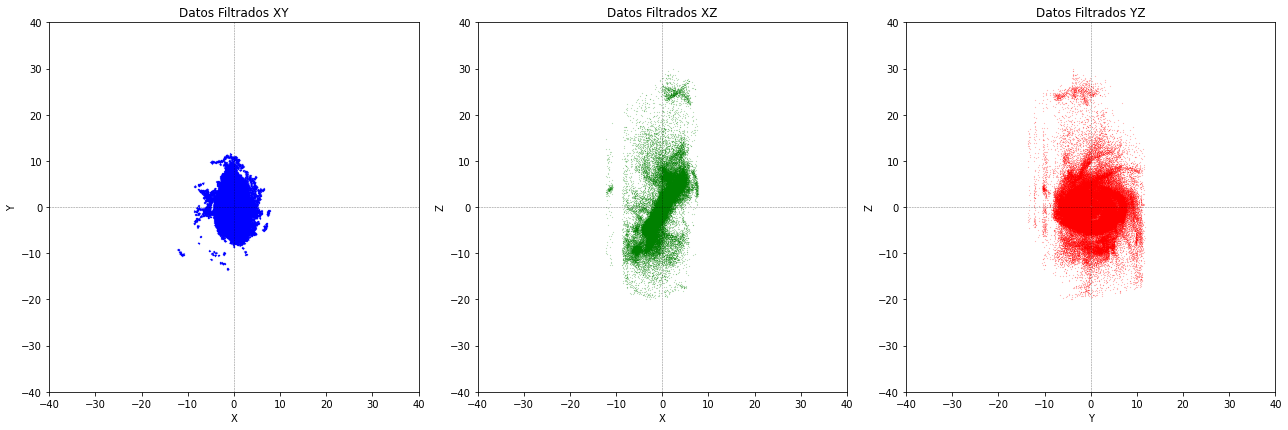

In [7]:
plot_orthogonal_projections(df_filtered, title_prefix="Datos Filtrados")

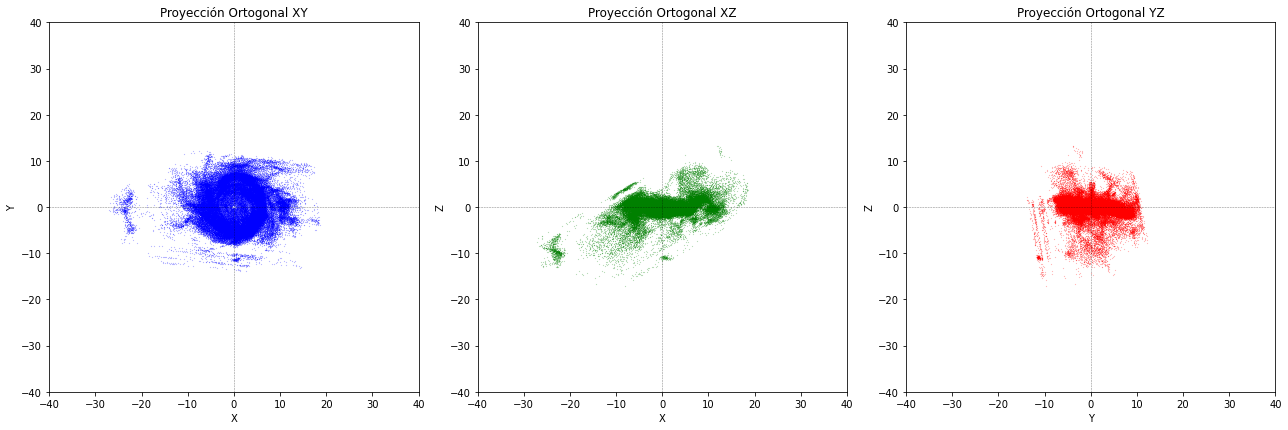

In [8]:
## corrección 
simulation = TNG50DataProcessor(data = df_filtered)  
rotated_data_positions,rotated_data_total = simulation.visualize_rotated_vector()

# Crear un DataFrame de los datos rotados para su uso posterior
rotated_df = pd.DataFrame({
    'x': rotated_data_positions[:, 0],
    'y': rotated_data_positions[:, 1],
    'z': rotated_data_positions[:, 2]
})


plot_orthogonal_projections(rotated_df)

In [9]:
idx='167397'
column_names = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho']
df_dbscan_data = pd.DataFrame(rotated_data_total, columns=column_names)

# Guardar como CSV para preservar la estructura y facilitar la lectura posterior
df_dbscan_data.to_csv(f'DATA/processed/halo_{idx}_datos_dbscan_sf.csv', index=False)

## halo_198184

### archivos sin filtrado (v_esc, energia interna)

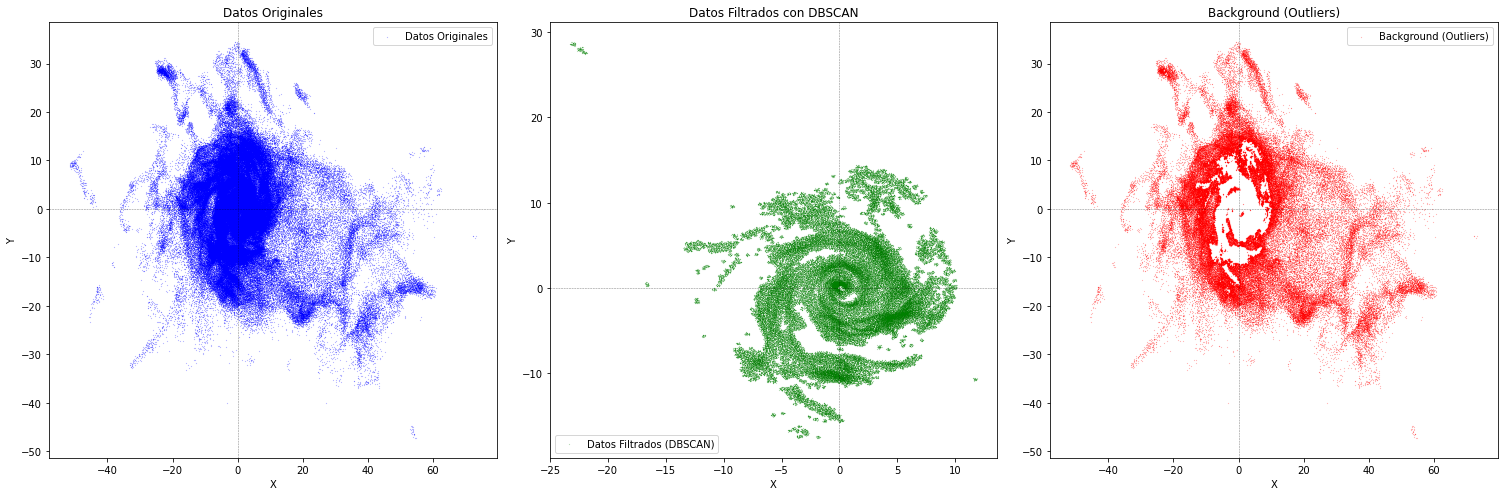

In [10]:
df_halo_198184 = archivos_dataframes[1]
df_filtered, background, eps, min_samples, labels= apply_dbscan_filter(df_halo_198184, eps =0.17, min_samples=20)

# Gráfico de los datos originales
plt.figure(figsize=(21, 7))

# Subplot 1: Datos Originales
plt.subplot(1, 3, 1)
plt.scatter(df_halo_198184['x'], df_halo_198184['y'], s=0.01, c='blue', label='Datos Originales')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Datos Originales')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Subplot 2: Datos Filtrados con DBSCAN
plt.subplot(1, 3, 2)
plt.scatter(df_filtered['x'], df_filtered['y'], s=0.01, c='green', label='Datos Filtrados (DBSCAN)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Datos Filtrados con DBSCAN')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Subplot 3: Background (Outliers)
plt.subplot(1, 3, 3)
plt.scatter(background['x'], background['y'], s=0.01, c='red', label='Background (Outliers)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Background (Outliers)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Ajustar la disposición de los subplots
plt.tight_layout()
plt.show()

In [11]:
total_points_origin = len(df_halo_198184)
total_points_dbscan = len(df_filtered)
total_points_background = len(background)
print(total_points_origin, total_points_dbscan, total_points_background)

171645 82340 89305


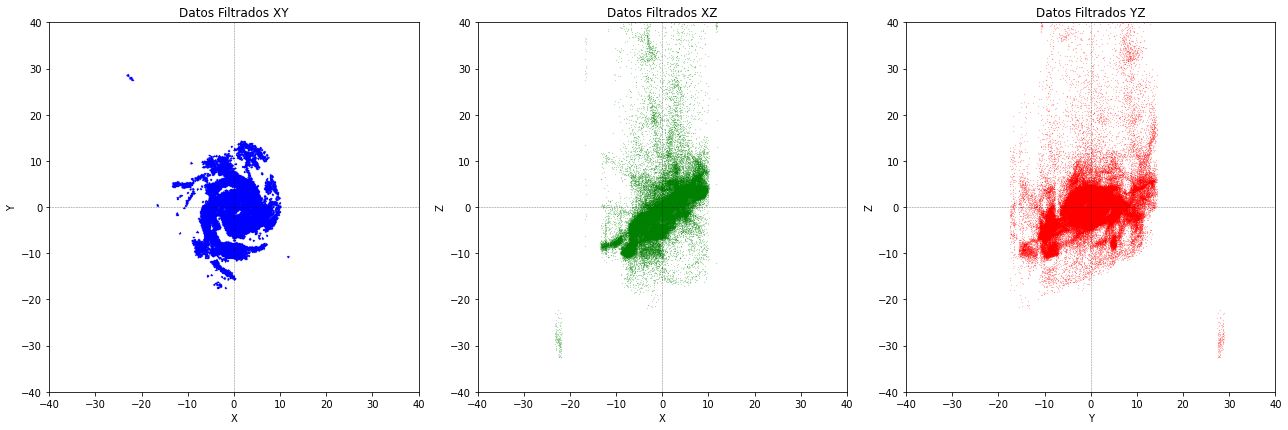

In [12]:
plot_orthogonal_projections(df_filtered, title_prefix="Datos Filtrados")


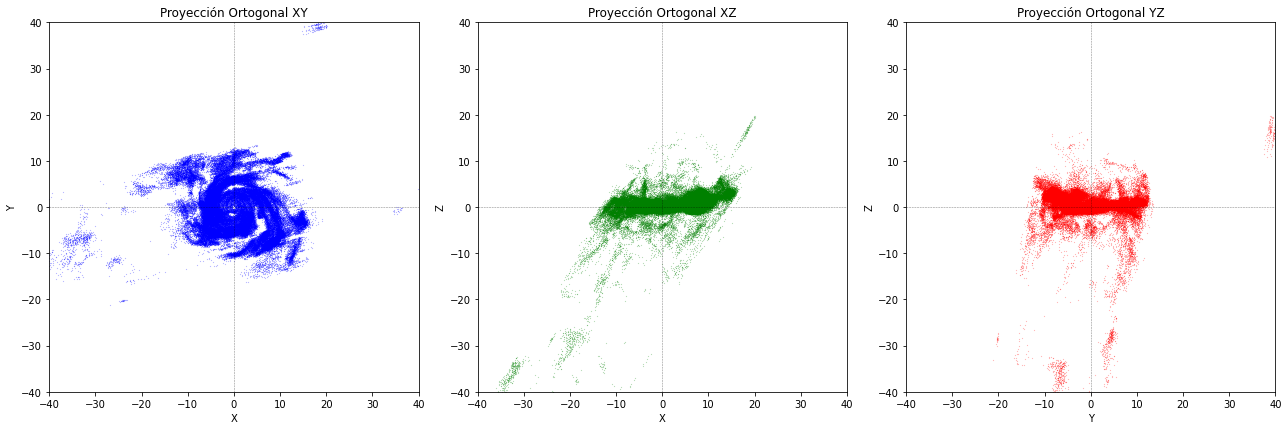

In [13]:
## corrección 
simulation = TNG50DataProcessor(data = df_filtered)  
rotated_data_positions,rotated_data_total = simulation.visualize_rotated_vector()

# Crear un DataFrame de los datos rotados para su uso posterior
rotated_df = pd.DataFrame({
    'x': rotated_data_positions[:, 0],
    'y': rotated_data_positions[:, 1],
    'z': rotated_data_positions[:, 2]
})


plot_orthogonal_projections(rotated_df)


In [14]:
idx='198184'
column_names = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho']
df_dbscan_data = pd.DataFrame(rotated_data_total, columns=column_names)

# Guardar como CSV para preservar la estructura y facilitar la lectura posterior
df_dbscan_data.to_csv(f'DATA/processed/halo_{idx}_datos_dbscan_sf.csv', index=False)

## halo_167393

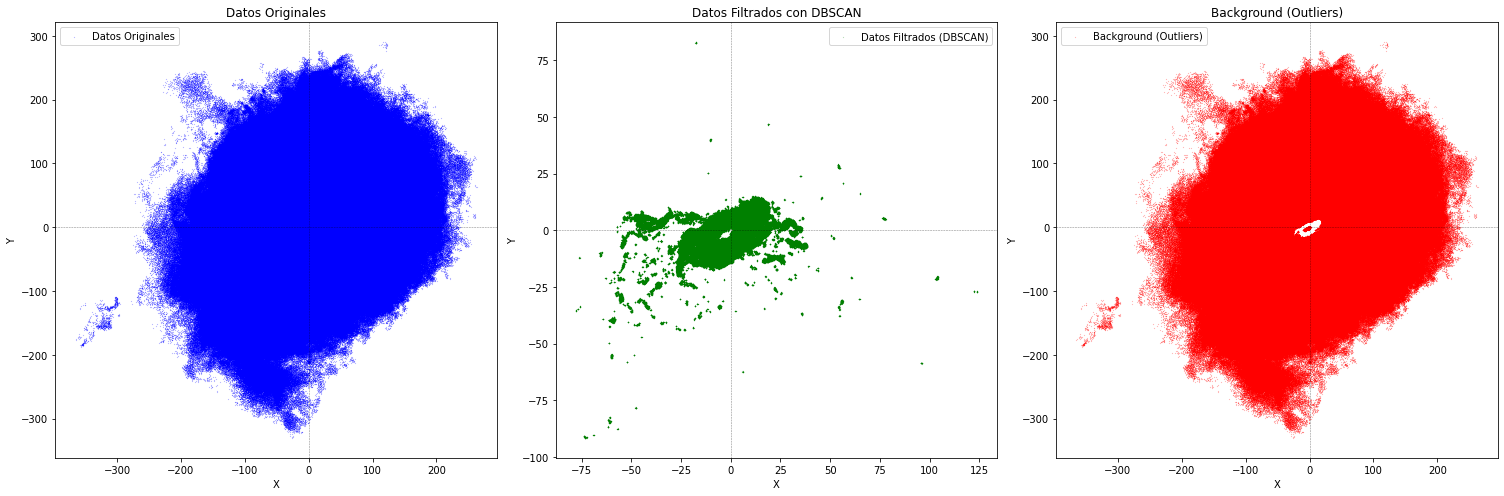

In [15]:
df_halo_167393 = archivos_dataframes[2]
df_filtered, background, eps, min_samples, labels= apply_dbscan_filter(df_halo_167393, eps =0.17, min_samples=20)

# Gráfico de los datos originales
plt.figure(figsize=(21, 7))

# Subplot 1: Datos Originales
plt.subplot(1, 3, 1)
plt.scatter(df_halo_167393['x'], df_halo_167393['y'], s=0.01, c='blue', label='Datos Originales')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Datos Originales')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Subplot 2: Datos Filtrados con DBSCAN
plt.subplot(1, 3, 2)
plt.scatter(df_filtered['x'], df_filtered['y'], s=0.01, c='green', label='Datos Filtrados (DBSCAN)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Datos Filtrados con DBSCAN')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Subplot 3: Background (Outliers)
plt.subplot(1, 3, 3)
plt.scatter(background['x'], background['y'], s=0.01, c='red', label='Background (Outliers)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Background (Outliers)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Ajustar la disposición de los subplots
plt.tight_layout()
plt.show()

In [16]:
total_points_origin = len(df_halo_167393)
total_points_dbscan = len(df_filtered)
total_points_background = len(background)
print(total_points_origin, total_points_dbscan, total_points_background)

4632364 631548 4000816


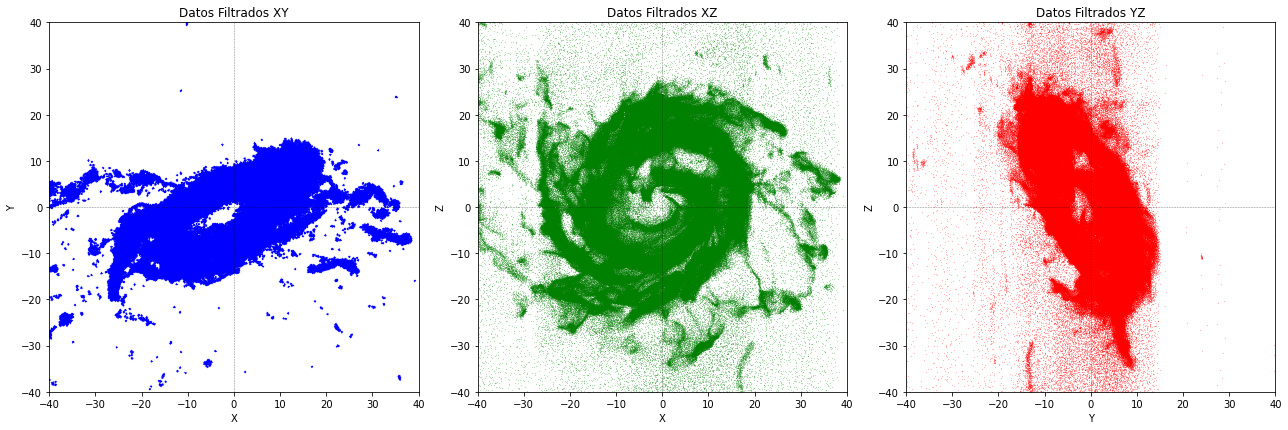

In [17]:
plot_orthogonal_projections(df_filtered, title_prefix="Datos Filtrados")


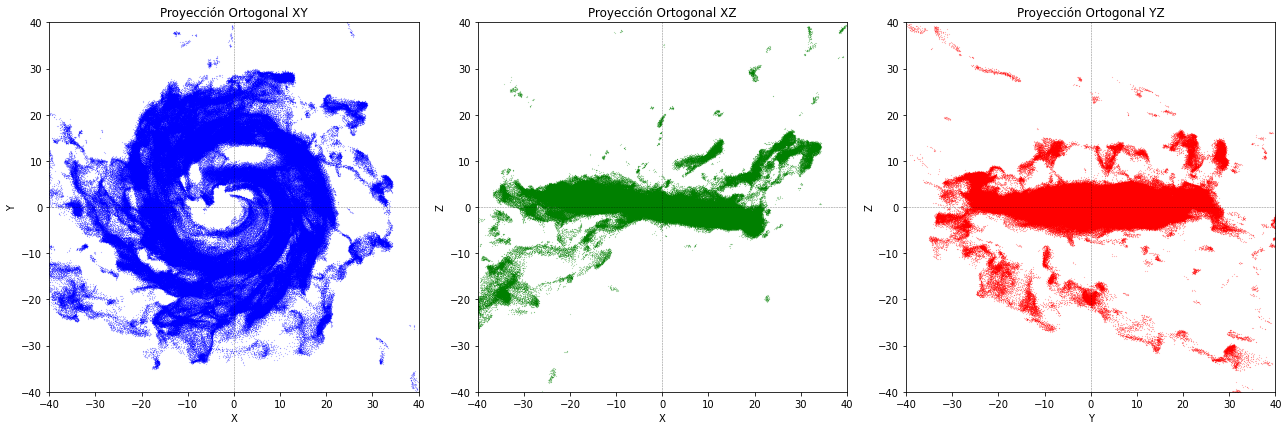

In [18]:
## corrección 
simulation = TNG50DataProcessor(data = df_filtered)  
rotated_data_positions,rotated_data_total = simulation.visualize_rotated_vector()

# Crear un DataFrame de los datos rotados para su uso posterior
rotated_df = pd.DataFrame({
    'x': rotated_data_positions[:, 0],
    'y': rotated_data_positions[:, 1],
    'z': rotated_data_positions[:, 2]
})


plot_orthogonal_projections(rotated_df)


In [19]:
idx='167393'
column_names = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho']
df_dbscan_data = pd.DataFrame(rotated_data_total, columns=column_names)

# Guardar como CSV para preservar la estructura y facilitar la lectura posterior
df_dbscan_data.to_csv(f'DATA/processed/halo_{idx}_datos_dbscan_sf.csv', index=False)

## halo_368843

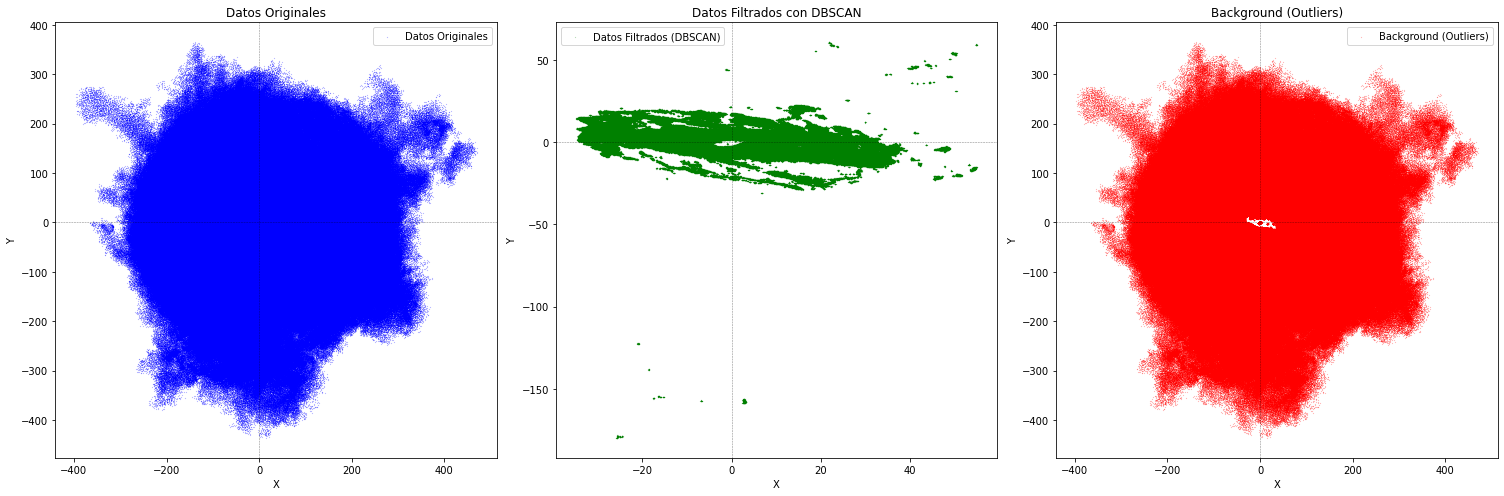

In [20]:
df_halo_368843 = archivos_dataframes[3]
df_filtered, background, eps, min_samples, labels= apply_dbscan_filter(df_halo_368843, eps =0.18, min_samples=20)

# Gráfico de los datos originales
plt.figure(figsize=(21, 7))

# Subplot 1: Datos Originales
plt.subplot(1, 3, 1)
plt.scatter(df_halo_368843['x'], df_halo_368843['y'], s=0.01, c='blue', label='Datos Originales')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Datos Originales')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Subplot 2: Datos Filtrados con DBSCAN
plt.subplot(1, 3, 2)
plt.scatter(df_filtered['x'], df_filtered['y'], s=0.01, c='green', label='Datos Filtrados (DBSCAN)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Datos Filtrados con DBSCAN')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Subplot 3: Background (Outliers)
plt.subplot(1, 3, 3)
plt.scatter(background['x'], background['y'], s=0.01, c='red', label='Background (Outliers)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Background (Outliers)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Ajustar la disposición de los subplots
plt.tight_layout()
plt.show()

In [21]:
total_points_origin = len(df_halo_368843)
total_points_dbscan = len(df_filtered)
total_points_background = len(background)
print(total_points_origin, total_points_dbscan, total_points_background)

3874218 789390 3084828


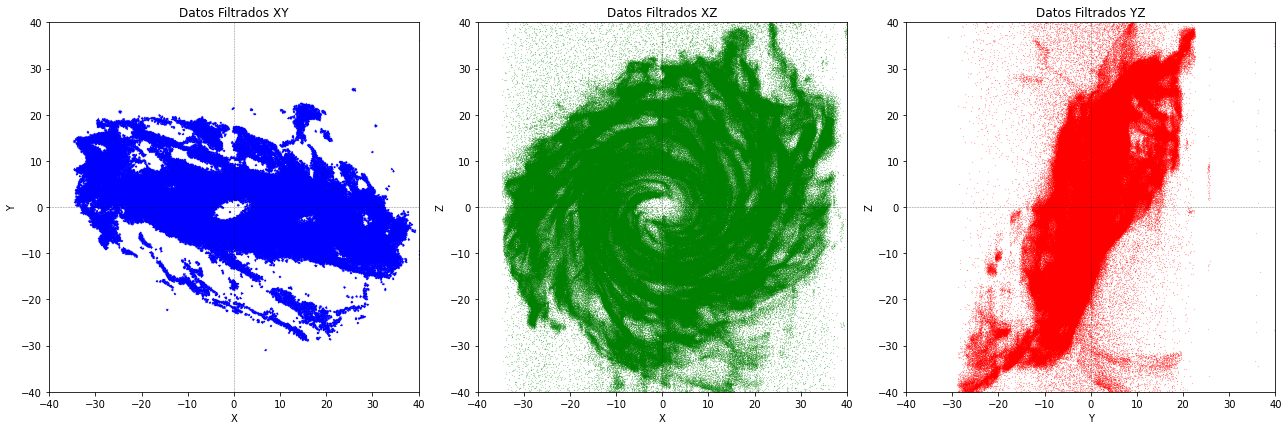

In [22]:
plot_orthogonal_projections(df_filtered, title_prefix="Datos Filtrados")


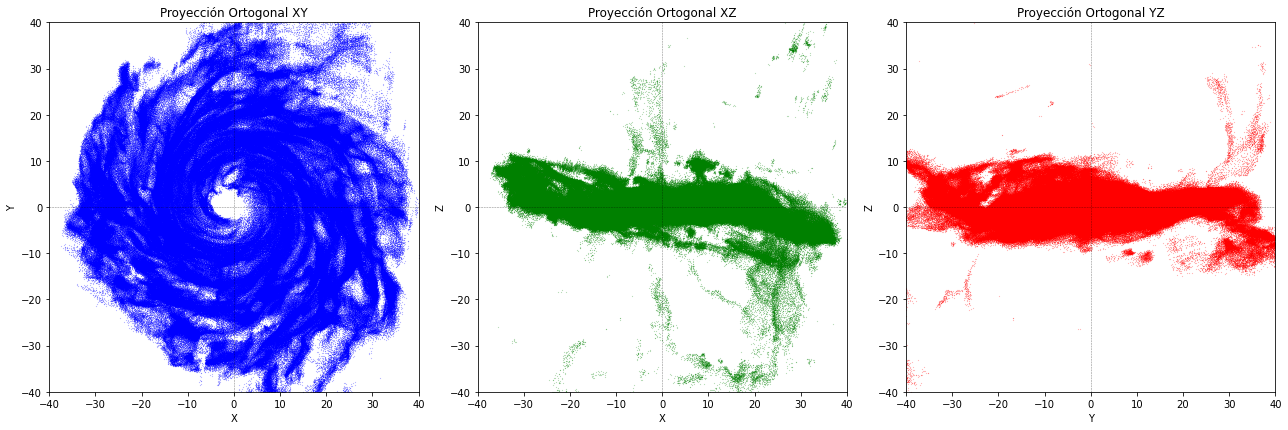

In [23]:
## corrección 
simulation = TNG50DataProcessor(data = df_filtered)  
rotated_data_positions,rotated_data_total = simulation.visualize_rotated_vector()

# Crear un DataFrame de los datos rotados para su uso posterior
rotated_df = pd.DataFrame({
    'x': rotated_data_positions[:, 0],
    'y': rotated_data_positions[:, 1],
    'z': rotated_data_positions[:, 2]
})


plot_orthogonal_projections(rotated_df)


In [24]:
idx='368843'
column_names = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho']
df_dbscan_data = pd.DataFrame(rotated_data_total, columns=column_names)

# Guardar como CSV para preservar la estructura y facilitar la lectura posterior
df_dbscan_data.to_csv(f'DATA/processed/halo_{idx}_datos_dbscan_sf.csv', index=False)

## halo_307487

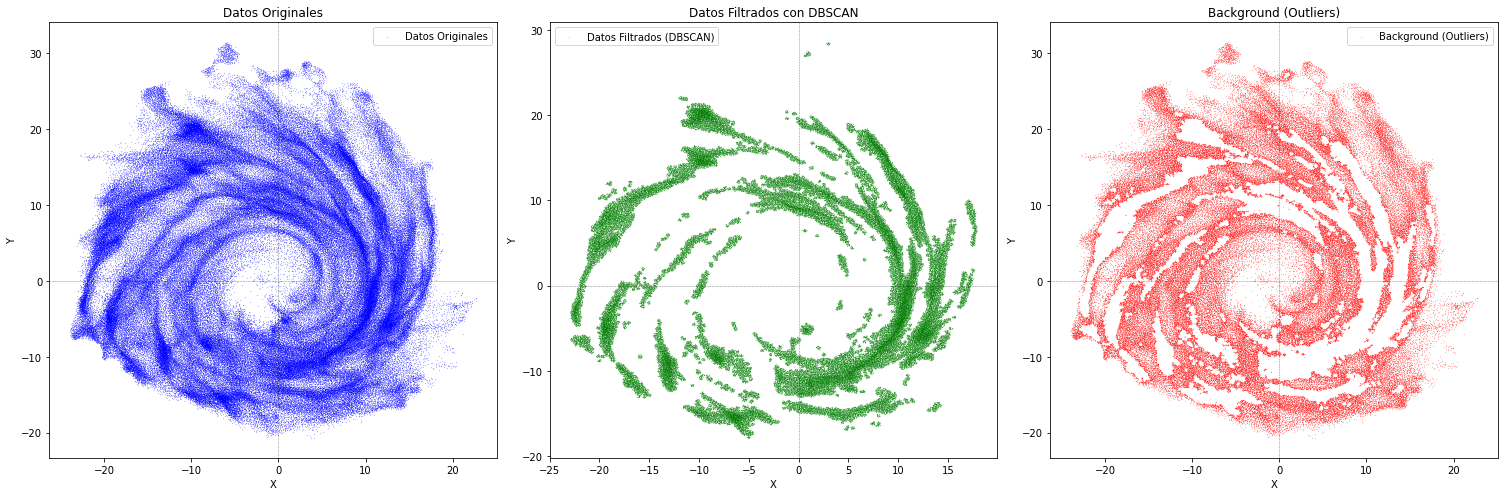

In [25]:
df_halo_307487 = archivos_dataframes[4]
df_filtered, background, eps, min_samples, labels= apply_dbscan_filter(df_halo_307487, eps =0.18, min_samples=10)

# Gráfico de los datos originales
plt.figure(figsize=(21, 7))

# Subplot 1: Datos Originales
plt.subplot(1, 3, 1)
plt.scatter(df_halo_307487['x'], df_halo_307487['y'], s=0.01, c='blue', label='Datos Originales')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Datos Originales')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Subplot 2: Datos Filtrados con DBSCAN
plt.subplot(1, 3, 2)
plt.scatter(df_filtered['x'], df_filtered['y'], s=0.01, c='green', label='Datos Filtrados (DBSCAN)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Datos Filtrados con DBSCAN')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Subplot 3: Background (Outliers)
plt.subplot(1, 3, 3)
plt.scatter(background['x'], background['y'], s=0.01, c='red', label='Background (Outliers)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Background (Outliers)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Ajustar la disposición de los subplots
plt.tight_layout()
plt.show()

In [26]:
total_points_origin = len(df_halo_307487)
total_points_dbscan = len(df_filtered)
total_points_background = len(background)
print(total_points_origin, total_points_dbscan, total_points_background)

198519 100161 98358


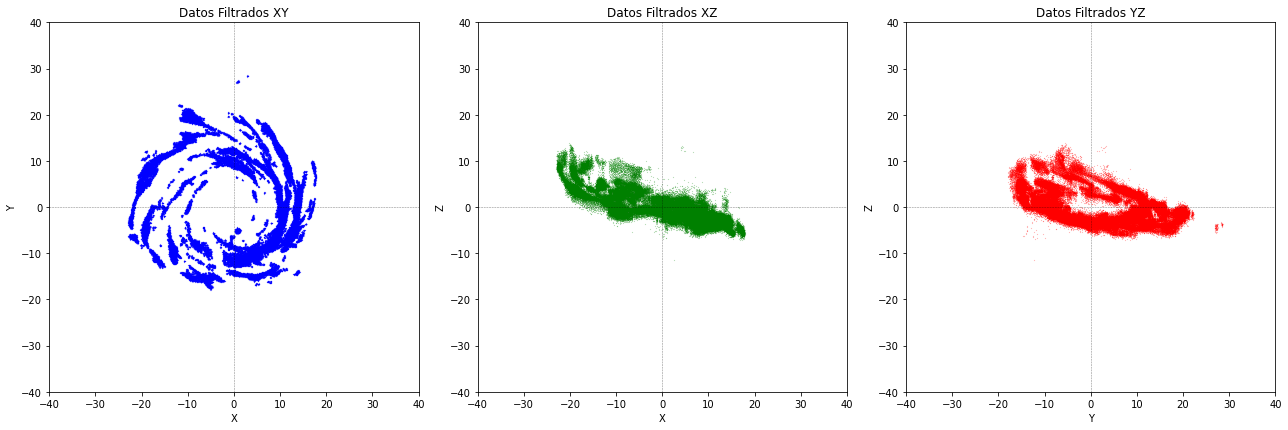

In [27]:
plot_orthogonal_projections(df_filtered, title_prefix="Datos Filtrados")


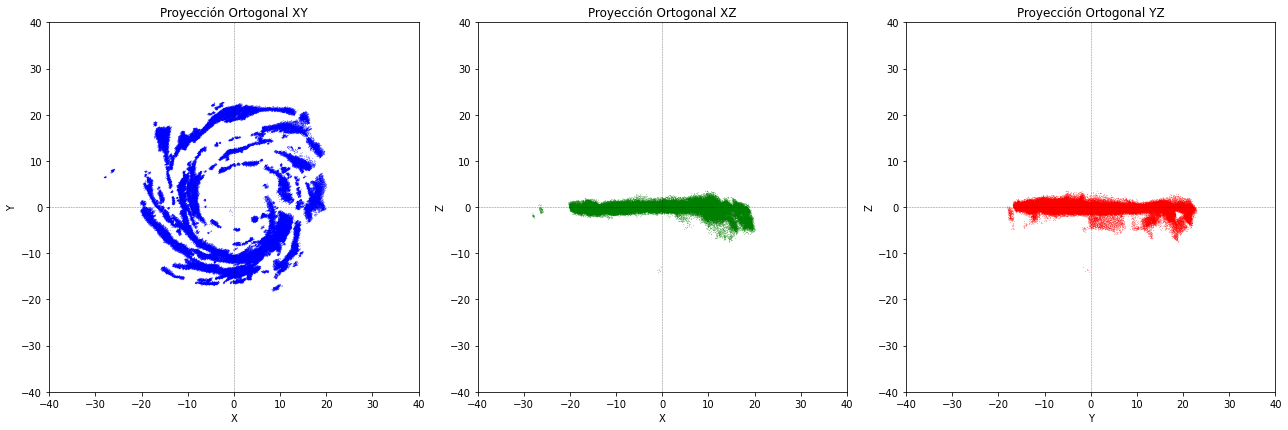

In [28]:
## corrección 
simulation = TNG50DataProcessor(data = df_filtered)  
rotated_data_positions,rotated_data_total = simulation.visualize_rotated_vector()

# Crear un DataFrame de los datos rotados para su uso posterior
rotated_df = pd.DataFrame({
    'x': rotated_data_positions[:, 0],
    'y': rotated_data_positions[:, 1],
    'z': rotated_data_positions[:, 2]
})


plot_orthogonal_projections(rotated_df)

In [29]:
idx='307487'
column_names = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho']
df_dbscan_data = pd.DataFrame(rotated_data_total, columns=column_names)

# Guardar como CSV para preservar la estructura y facilitar la lectura posterior
df_dbscan_data.to_csv(f'DATA/processed/halo_{idx}_datos_dbscan_sf.csv', index=False)

## halo_117260


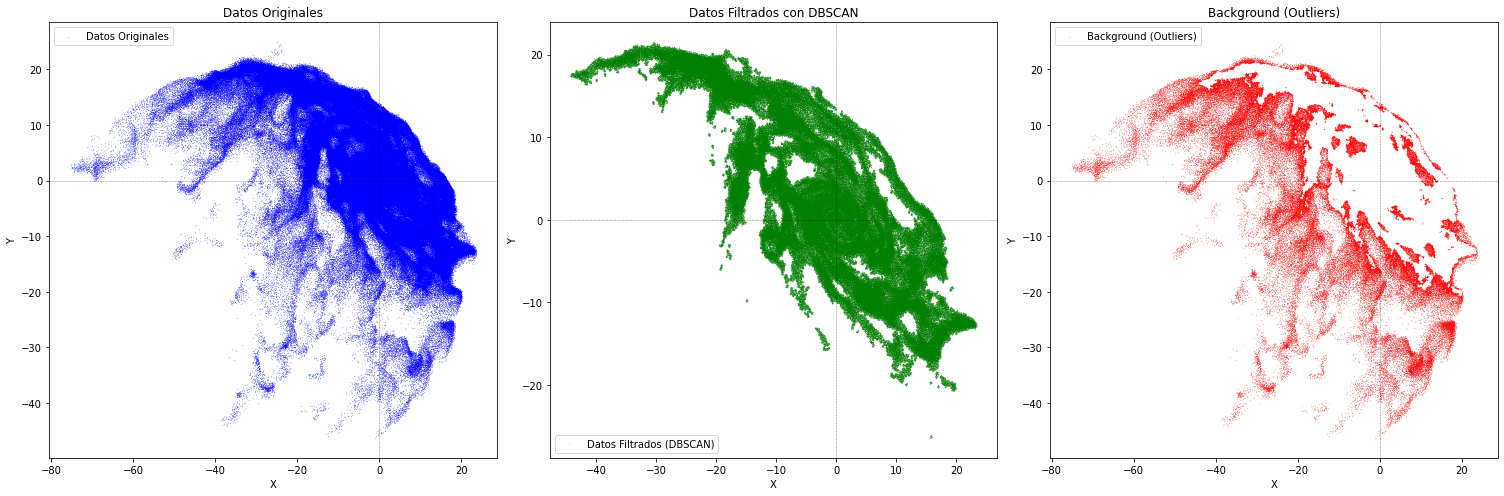

In [30]:
df_halo_117260 = archivos_dataframes[5]
df_filtered, background, eps, min_samples, labels= apply_dbscan_filter(df_halo_117260, eps =0.17, min_samples=20)

# Gráfico de los datos originales
plt.figure(figsize=(21, 7))

# Subplot 1: Datos Originales
plt.subplot(1, 3, 1)
plt.scatter(df_halo_117260['x'], df_halo_117260['y'], s=0.01, c='blue', label='Datos Originales')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Datos Originales')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Subplot 2: Datos Filtrados con DBSCAN
plt.subplot(1, 3, 2)
plt.scatter(df_filtered['x'], df_filtered['y'], s=0.01, c='green', label='Datos Filtrados (DBSCAN)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Datos Filtrados con DBSCAN')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Subplot 3: Background (Outliers)
plt.subplot(1, 3, 3)
plt.scatter(background['x'], background['y'], s=0.01, c='red', label='Background (Outliers)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Background (Outliers)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()

# Ajustar la disposición de los subplots
plt.tight_layout()
plt.show()

In [31]:
total_points_origin = len(df_halo_117260)
total_points_dbscan = len(df_filtered)
total_points_background = len(background)
print(total_points_origin, total_points_dbscan, total_points_background)

400298 318686 81612


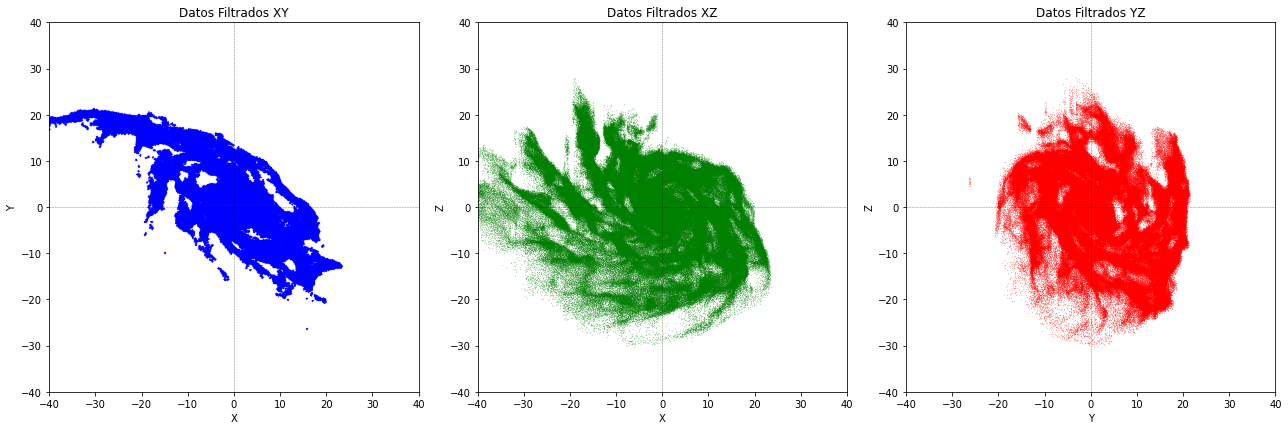

In [32]:
plot_orthogonal_projections(df_filtered, title_prefix="Datos Filtrados")


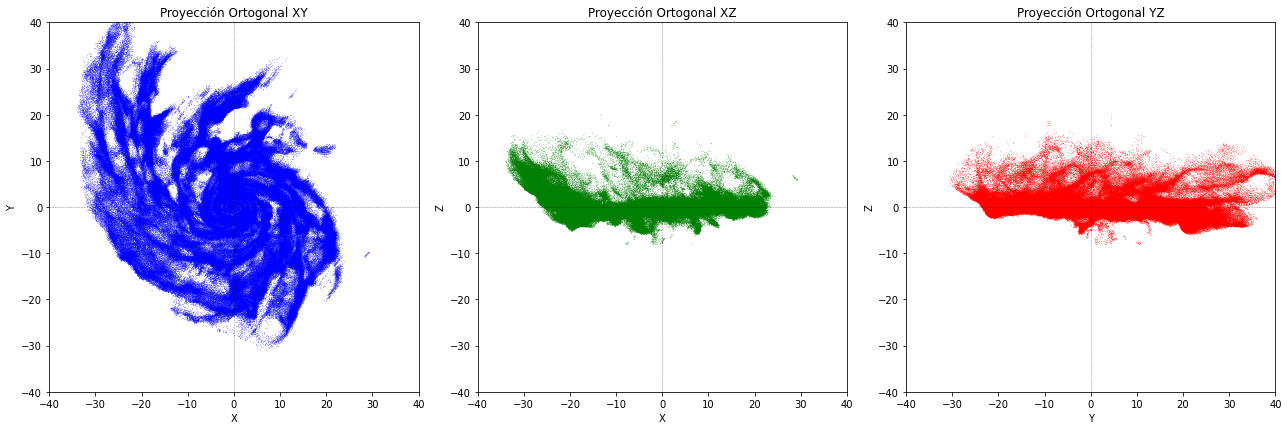

In [33]:
## corrección 
simulation = TNG50DataProcessor(data = df_filtered)  
rotated_data_positions,rotated_data_total = simulation.visualize_rotated_vector()

# Crear un DataFrame de los datos rotados para su uso posterior
rotated_df = pd.DataFrame({
    'x': rotated_data_positions[:, 0],
    'y': rotated_data_positions[:, 1],
    'z': rotated_data_positions[:, 2]
})


plot_orthogonal_projections(rotated_df)

In [34]:
idx='117260'
column_names = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho']
df_dbscan_data = pd.DataFrame(rotated_data_total, columns=column_names)

# Guardar como CSV para preservar la estructura y facilitar la lectura posterior
df_dbscan_data.to_csv(f'DATA/processed/halo_{idx}_datos_dbscan_sf.csv', index=False)

In [ ]:
# Crear figuras para graficar los resultados
fig, axs = plt.subplots(3, 2, figsize=(18, 18))
axs = axs.flatten()

# Iterar sobre los archivos de halo
for idx, file_name in enumerate(halo_files):
    file_path = f'{data_dir}/{file_name}'
    
    # Cargar y procesar los datos usando TNG50DataProcessor
    simulation = TNG50DataProcessor(file_path)
    
    # Calcular el centro de masa y el momento angular total
    center_of_mass = simulation.calculate_center_of_mass_new(2.63)
    total_angular_momentum = simulation.calculate_total_angular_momentum()
    
    # **Alinear el momento angular con el eje Z**
    rotation_matrix = simulation.align_with_z_axis(total_angular_momentum)
    
    # Aplicar rotación a las posiciones y velocidades usando la nueva matriz de rotación
    rotated_vectors_position = simulation.apply_rotation(rotation_matrix, simulation.accumulated_data[:, :3])
    rotated_vectors_velocity = simulation.apply_rotation(rotation_matrix, simulation.accumulated_data[:, 3:6])
    
    # Concatenar los datos rotados y otros datos relevantes (e.g., energía, potencial)
    rotated_data = np.concatenate([rotated_vectors_position, rotated_vectors_velocity, simulation.accumulated_data[:, 6:]], axis=1)
    potential = simulation.accumulated_data[:, 9]

    # Calcular magnitudes y velocidades de escape
    calculator = VelocityEscapeCalculator(rotated_data, potential)
    calculator.calculate_magnitudes()
    calculator.calculate_escape_velocity()
    processed_data = calculator.get_processed_data()

    # Crear el grid de velocidades
    grid_data, v_esc_midpoints, weighted_avg_velocity_per_column, max_avg_velocity, v_circ_min, v_circ_max, v_esc_min, v_esc_max = create_velocity_grid(processed_data)

    # Filtrar los datos por velocidad promedio
    filtered_data = filter_data_by_velocity(processed_data, max_avg_velocity, v_esc_midpoints, weighted_avg_velocity_per_column)

    # Aplicar Convex Hull a las posiciones rotadas
    hull_3d, points_3d_datos, esta_dentro_hull, max_distance, sample_points = apply_convex_hull_filter(rotated_vectors_position, filtered_data, rotated_data, idx)

    # Visualizar resultados en la subfigura correspondiente
    ax = axs[idx]
    ax.imshow(grid_data, origin='lower', aspect='auto', extent=[v_esc_min, v_esc_max, v_circ_min, v_circ_max], cmap='viridis')
    ax.scatter(processed_data['escape_velocity'], processed_data['velocity_magnitude'], color='red', s=1, alpha=0.45, label='Real Data Points')
    ax.axhline(y=max_avg_velocity, color='white', linestyle='--', label=f'Max Avg Velocity = {max_avg_velocity:.2f}')
    ax.scatter(v_esc_midpoints, weighted_avg_velocity_per_column, color='black', s=40, label='Average Velocity Per Column')
    ax.set_title(f'{file_name}')
    ax.set_xlabel(r'$V_{esc}$')
    ax.set_ylabel(r'$V_{circ}$')
    ax.legend(loc=2)
    ax.grid(True)
    
    # Mostrar la gráfica del Convex Hull
    visualize_convex_hull(hull_3d, sample_points, points_3d_datos, esta_dentro_hull, file_name)

# Ajustar el diseño de las subfiguras
plt.tight_layout()
plt.show()



In [ ]:

# Nombre de los archivos
halo_files = ['halo_0_datos_dentro_hull.csv', 'halo_1_datos_dentro_hull.csv', 'halo_2_datos_dentro_hull.csv', 'halo_3_datos_dentro_hull.csv', 'halo_4_datos_dentro_hull.csv']

# Cargar cada archivo en un DataFrame de Pandas
archivos_dataframes_hull = []
for archivo in halo_files:
    # Construir la ruta completa al archivo
    ruta_completa = os.path.join(data_dir_processed, archivo)
    
    # Leer el archivo en un DataFrame
    df = pd.read_csv(ruta_completa, sep=',', names=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho'], header=0)
    archivos_dataframes_hull.append(df)

# Mostrar la lista de DataFrames para verificar la carga
for i, df in enumerate(archivos_dataframes_hull):
    print(f"Archivo {halo_files[i]} cargado con {len(df)} filas.")